##Imports

In [7]:
"""
Stefan Schmohl, Dominik Laupheimer, 
Institute for Photogrammetry, 
University of Stuttgart, 2022
"""

# # # # IMPORTS
import os
import time
import sklearn
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader 
from torchvision import datasets, models, transforms

# Connect to google drive and import helper scripts
from google.colab import drive
a = drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ColabNotebooks/PatternRecognition_Lab3/src_python')
from utils import *

ModuleNotFoundError: No module named 'google'

## Settings

In [ ]:
# # # # SETTINGS
class_names = {0: 'building', 1: 'car', 2: 'clutter'}   # label: name

pretrained    = True    
architecture  = models.resnet18     # (function pointer)
lr = 0.001                          # learning rate
lr_step_size  = 20
lr_gamma      = 0.7
weight_decay  = 0.1
batch_size    = 32
device        = 'cuda'              # 'cuda' (GPU) or 'cpu'

id_image_train = [2, 13]               # [row, column]
id_image_valid = [2, 15]               # [row, column] [2,15] randomly chosen
id_image_test  = [3, 14]               # [row, column]

## Loading the Training + Validation Data

In [ ]:
crops_train, gt_train = load_crops(*id_image_train)
crops_valid, gt_valid = load_crops(*id_image_valid)

print("Number of input channels:      ", crops_train.shape[2])
print("Number of training samples:    ", crops_train.shape[-1])
print("Number of validation samples:  ", crops_valid.shape[-1])

# Plot 8 random samples (RGB):
plot_samples(crops_train, gt_train, class_names, 8)

NameError: name 'load_crops' is not defined

## Preparing the Data for the Network (via `DataLoader`s)
Use `DataLoader` and `TensorDataset` to **feed data in a mini-batch-wise fashion** to the network. 

NOTE: Can also be used for data-augmentation, e.g., see `transforms` for `ImageFolder` dataset.

In [ ]:
def prep_data(images, labels, batch_size=64, shuffle=False):
  images_ = np.moveaxis(images, [0, 1, 2, 3], [2,3,1,0]) # (H,W,C,N) => (N,C​,H,W) 
  images_ = torch.tensor(images_).float()
  labels_ = torch.tensor(labels).squeeze().long()
  dataset = TensorDataset(images_, labels_)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader

# dataloader for training
dataloader_train = prep_data(crops_train, gt_train, batch_size=batch_size, shuffle=True)

#
# TODO: create validation dataloader
#
# dataloader for validation
dataloader_val = prep_data(crops_val, gt_val, batch_size=batch_size, shuffle=False)


## Defining Data Augmentations
Create a cascading list of augmentation transformations with out-of-the-box TorchVision random image transformation functions.

In [ ]:
aug_trafos = transforms.Compose([
  transforms.RandomHorizontalFlip(0.5),
  transforms.RandomVerticalFlip(0.5),
  transforms.RandomResizedCrop((crops_train.shape[0], crops_train.shape[1]), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
  transforms.RandomRotation(degrees=(-10, 10))
])

## Creating the Network
**Download** the (pretrained) network.

**Replace first layer** to accept `cin = 5 = [RGBIRnDSM]` input channels. **Replace last layer** to output probabilities for `cout = 3 = [building, car, clutter]` classes (and to remove the implicit 256x256 input size requirement).

We make sure that all layers use the same format (`float()`) and move the network to the GPU.

In [ ]:
net = architecture(pretrained=pretrained, progress=True)
# print(net) # Display network architecture
cin = crops_train.shape[2]
cout = len(class_names)

#
# TODO: replace first and last network layer.
#  - Find the names of those layers trough print(net)
#  - Redefine those layers with net.layername = torch.nn.XYZ(...)
#  - For the first layer (torch.nn.Conv2D), use the same parameters except the number of input channels (first parameter)
#  - For the last layer (torch.nn.Linear), use the same parameters except out_features.
#

# Replace the first layer (name: 'conv1')
net.conv1 = torch.nn.Conv2d(cin, net.conv1.out_channels, kernel_size=net.conv1.kernel_size, stride=net.conv1.stride, padding=net.conv1.padding)

# Replace the last layer (name: 'fc')
net.fc = torch.nn.Linear(net.fc.in_features, cout)

# transform the model parameters to float
net.float();

#
# TODO: transfer network to the device defined in settings.
#
net.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


## Training / Fine-Tuning
Use  
`net.train()` to put the network(-modules) into training mode and  
`net.eval()` respectively to activate the inference mode.  
The mode is relevant for specific layers, e.g., dropout and batch normalization.

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
loss_fu = nn.CrossEntropyLoss()

log = []
tic = time.time()
for i in range(100):

  # # # # TRAINING (per epoch)
  net.train()
  track_loss = []  # running loss
  track_acc = []   # running accuracy
  
  # iterate over mini-batches
  for batch in dataloader_train:  # batch size has been defined while defining the DataLoader
    inputs = batch[0].to(device)
    labels = batch[1].to(device)
    inputs_augm = aug_trafos(inputs)    # apply data augmentations

    #
    # TODO: training over each mini-batch (see demo script)
    # 
    # Training over each mini-batch
    optimizer.zero_grad()  # Zero the gradients
    outputs = net(inputs_augm)  # Forward pass
    loss = loss_fu(outputs, labels)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights


    # update tracking containers of the mini-batches (iterations)
    oa = torch.sum(torch.argmax(outputs,1) == labels).item() / len(labels) * 100
    track_loss.append(loss.item())
    track_acc.append(oa)


  # update tracked quantities (epochs)
  lr = optimizer.param_groups[0]["lr"]
  loss = np.mean(track_loss)
  acc = np.mean(track_acc)
  print("Epoch %2d,   lr: %.9f,   loss: %.4f,   acc: %5.1f" % (i, lr, loss, acc), end='')
  log.append({'loss': loss, 'acc': acc})
  lr_scheduler.step()                   # decrease learning rate


  # # # # VALIDATION (per epoch)
  net.eval()


  #
  # TODO: run validation set trough the network. Record loss and accuracy
  #
  # Run validation set through the network
  valid_loss = []
  valid_acc = []

  for batch in dataloader_val:
      inputs = batch[0].to(device)
      labels = batch[1].to(device)
      outputs = net(inputs)
      loss = loss_fu(outputs, labels)
      valid_loss.append(loss.item())

      _, preds = torch.max(outputs, 1)
      acc = torch.sum(preds == labels).item() / len(labels) * 100
      valid_acc.append(acc)

  valid_loss = np.mean(valid_loss)
  valid_acc = np.mean(valid_acc)



  print(",  valid_loss: %.4f,  valid_acc: %5.1f" % (valid_loss, valid_acc))
  log[-1]['valid_loss'] = valid_loss
  log[-1]['valid_acc'] = valid_acc

print("Finished Training after:", time.time()-tic, "sec.")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


NameError: ignored

## Plotting Training Metrics

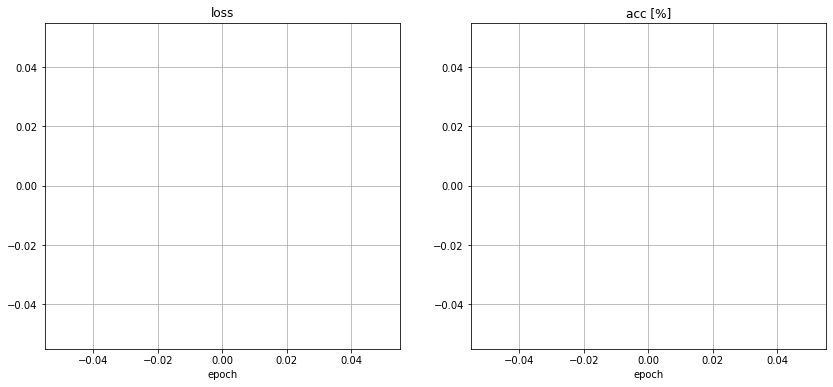

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
def p(ax, d, t):
  ax.plot(d)
  ax.set_title(t)
  ax.set_xlabel('epoch')
  ax.grid(True)
p(ax1, [x['loss'] for x in log], 'loss')
p(ax2, [x['acc'] for x in log], 'acc [%]')

#
# TODO: Plot valid metrics into same axes.
#
p(ax1, [x['valid_loss'] for x in log], 'valid loss')
p(ax2, [x['valid_acc'] for x in log], 'valid acc [%]')



plt.show()

## Inferencing on Test Data

In [ ]:
net.eval()
with torch.no_grad():

  #
  # TODO: 
  #  - Import test crops & create dataloader
  #  - Over all mini-batches:
  #     - Predict crop-wise network outputs for test dataset
  #     - collect the corresponding gt
  #  - Bring predictions & gt to cpu with .detach().cpu().
  #  - Use torch.nn.functional.softmax to convert the network outputs to probabilities.
  #  - Use torch.max to select per sample the class with the highest probability as prediction.
  #
  #  => variables (expected in further script):
  #        gt     = tensor of ground truth class labels per crop / bounding box
  #        preds  = tensor of predicted class label per crop / bounding box.
  #        probs  = tensor of probabilitiy of predicted class label per crop / bounding box.
  #
  # Tips:
  #   - use torch.cat() to concatinate list of tensors (per mini batch) to a single tensor.
  #   - max, argmax = torch.max()
  #
# Import test crops & create dataloader
  crops_test, gt_test = load_crops(id_image_test)  # Replace row and col with appropriate values
  dataloader_test = prep_data(crops_test, gt_test, batch_size=batch_size, shuffle=False)

  gt = []
  preds = []
  probs = []

  for batch in dataloader_test:
      inputs = batch[0].to(device)
      labels = batch[1].to(device)
      outputs = net(inputs)
      probabilities = torch.nn.functional.softmax(outputs, dim=1)
      _, predictions = torch.max(probabilities, 1)

      gt.append(labels.detach().cpu())
      preds.append(predictions.detach().cpu())
      probs.append(probabilities.detach().cpu())

  gt = torch.cat(gt)
  preds = torch.cat(preds)
  probs = torch.cat(probs)



SyntaxError: ignored

## Evaluating

In [ ]:
# performance metrics
acc       = sklearn.metrics.accuracy_score(gt, preds)
recall    = sklearn.metrics.recall_score(gt, preds, average=None)
precision = sklearn.metrics.precision_score(gt, preds, average=None)
f1        = sklearn.metrics.f1_score(gt, preds, average=None)
print("Overall Test Accuracy: %5.1f %%" % (acc*100))
print("Recall:    ", recall*100, '[%]')
print("Precision: ", precision*100, '[%]')
print("F1 score:  ", f1*100, '[%]')

# confusion matrix
cm = confusion_matrix(gt, preds)
disp = CMD(confusion_matrix=cm, display_labels=list(class_names.values()))
disp = disp.plot(include_values=True, cmap='Greens', ax=None, xticks_rotation='horizontal')
plt.show()

NameError: ignored

## Plotting the Test Results
After loading the **original bounding box coordinates** and the **RGB test image**, plot predictions onto RGB image and save to drive.

In [ ]:
img = load_img(*id_image_test)
bbs = load_bbs(*id_image_test)

img_name = '%d_%d ' % tuple(id_image_test)
colors = ['b', 'y', 'r']
plot_bbs(img, bbs, gt,           colors=colors, title=img_name + ' GT')
plot_bbs(img, bbs, preds, probs, colors=colors, title=img_name + ' Prediction')

NameError: ignored